# Import Libraries

In [55]:
import skimage.morphology 
import skimage.measure as measure
import skimage.segmentation
import numpy as np
import sys
import time 
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
import skimage.exposure as exposure
import skimage.segmentation as seg
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import skimage.util as util
import skimage.filters as filt
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import neighbors, datasets, metrics
import sklearn.svm
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
np.set_printoptions(threshold=sys.maxsize)

# Implementation of HoCS : Curvature

In [18]:
# Implementation of HoCS : Curvature

def HoCS(B, min_scale, max_scale, increment, num_bins):
    
    #initialize parameters
    featureV=np.zeros([1,(num_bins*(np.floor((max_scale-min_scale)/increment)+1)).astype(int)]);    
    p=0;
    radius=min_scale;  
    
    # select boundary of the object      
    Boundary=skimage.segmentation.find_boundaries(B, connectivity=1, mode='inner', background=0)*1    
    BPoints=np.sum(Boundary*1);
    
    
    #Calculate feature vector for different scales
    while (radius<=max_scale):
        
        #Pad input array to mprepare it for processing with the mask of boundary pixels which are near the image border. 
        BPadded=np.pad(B, radius, mode='constant',constant_values=0)
        
        #generate mask for given radius
        masks=skimage.morphology.disk(radius, dtype=bool)*1;
        kArray=np.zeros_like(B)+2.0;
        
        #calculate curvature for each boundary point
        for i,j in np.argwhere(Boundary>0):            
            kArray[i,j]=(np.sum(BPadded[i:i+2*radius+1,j:j+2*radius+1]*masks)/np.sum(masks))
        
        #create normalized histogram and store in feature vector
        hist,others=np.histogram(kArray, bins=num_bins, range=(0.0,1.0), density=None)
        featureV[0,p*num_bins:(p+1)*num_bins]=skimage.exposure.rescale_intensity(hist, in_range=(0,BPoints), out_range=(0.0,1.0));
        
        # increase parameters for next iteration
        p=p+1;
        radius=radius+increment
        
    #return the HoCS feature vector
    return featureV[0]

# Loading Training and Testing Dataset

In [19]:
# Dataset Loading

# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# summarize loaded dataset
print('Training dataset size: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing dataset size: X=%s, y=%s' % (testX.shape, testy.shape))

Training dataset size: X=(60000, 28, 28), y=(60000,)
Testing dataset size: X=(10000, 28, 28), y=(10000,)


# Display sample data

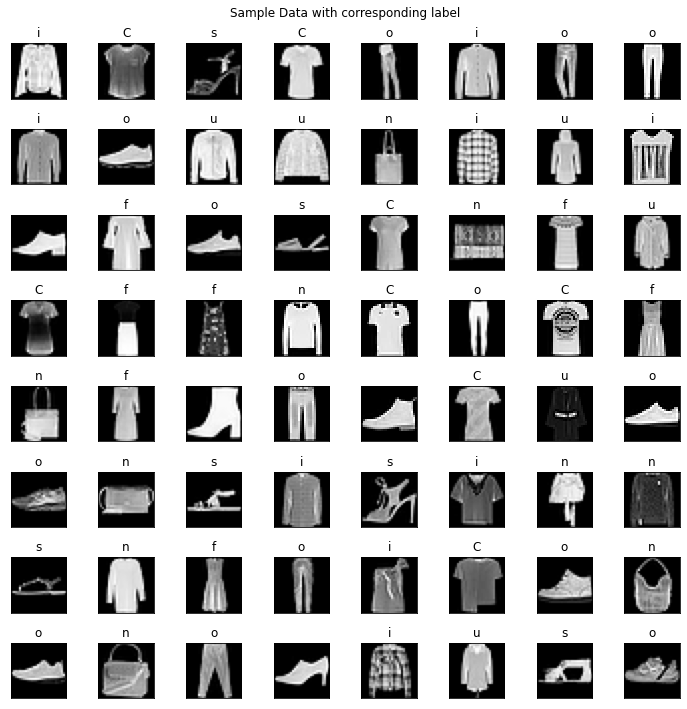

In [72]:
# plot few images with corresponding label
plt.figure(figsize=(10, 10))
for i in range(64):
    a=imspaceRegionFilledTrainX[300+1+i];
    b=np.reshape(a,(r,c));
    
    # define subplot
    plt.subplot(8,8,1+i,xticks = [], yticks =[])
    plt.tight_layout()
    plt.title(str[trainy[301+i]])    
    plt.suptitle('Sample Data with corresponding label')
        
    # plot raw pixel data
    plt.imshow(trainX[301+i], cmap=plt.get_cmap('gray')) 

# Image preprocessing and Feature Extraction

In [21]:
#Boundary selection, object structure extraction and Feature selection

#initialize parameters
min_scale=3;
max_scale=10;
increment=2;
num_bins=10;

# initialize variables for creating training feature array
[n,r,c]=np.shape(trainX)
imspaceTrainX = np.zeros((n,r*c))
imspaceRegionFilledTrainX = np.zeros((n,r*c))
trainXBinary = np.zeros_like(trainX)
trainXBinaryRegionFilled = np.zeros_like(trainX)
trainCurvatureArray=np.zeros(([np.shape(trainX)[0],(num_bins*(np.floor((max_scale-min_scale)/increment)+1)).astype(int)]), dtype=float);

#initialize variables for creating testing feature array
[n1,r1,c1]=np.shape(testX)
imspaceTestX = np.zeros((n1,r1*c1))
imspaceRegionFilledTestX = np.zeros((n1,r1*c1))
testXBinary = np.zeros_like(testX)
testXBinaryRegionFilled = np.zeros_like(testX)
testCurvatureArray=np.zeros(([np.shape(testX)[0],(num_bins*(np.floor((max_scale-min_scale)/increment)+1)).astype(int)]), dtype=float);


#loop for creating training feature array
for i,im in enumerate(trainX[:]):
    
    # optimal threshold using iterative method
    thresh = filt .threshold_li (im)
    
    #generate binary image
    trainXBinary[i] = (im > thresh)*1;
    
    # Region Filling
    L = skimage.morphology.label(trainXBinary[i])
    props = measure.regionprops(L)    
    label = props[np.argmax( np.array([x['area'] for x in props]) )]['label']
    trainXBinaryRegionFilled[i] = binary_fill_holes(L == label)
    
    # Save Region Filled Binary image to calculate performance of region filling
    imspaceRegionFilledTrainX[i]= np.reshape(trainXBinaryRegionFilled[i],r*c)
    
    #Save feature array for PCA based reduction using Binary image
    imspaceTrainX[i]= np.reshape(trainXBinary[i],r*c)
    
    # generate curvature features
    #Region Filled Binary image has been passed to ignore the boundaries of holes in the region for curvature features.
    trainCurvatureArray[i]= HoCS(trainXBinaryRegionFilled[i],min_scale, max_scale, increment, num_bins);
    
#loop for creating testing feature array    
for i,im in enumerate(testX[:]):
    
    # optimal threshold using iterative method
    thresh = filt .threshold_li (im)
    
    #generate binary image
    testXBinary[i] = (im > thresh)*1;
    
    # Region Filling
    L = skimage.morphology.label(testXBinary[i])
    props = measure.regionprops(L)    
    label = props[np.argmax( np.array([x['area'] for x in props]) )]['label']
    testXBinaryRegionFilled[i] = binary_fill_holes(L == label)
    
    # Save Region Filled Binary image to calculate performance of region filling
    imspaceRegionFilledTestX[i]= np.reshape(testXBinaryRegionFilled[i],r1*c1)
    
    
    #Save feature array for PCA based reduction using Binary image
    imspaceTestX[i]= np.reshape(testXBinary[i],r1*c1)
    
    # generate curvature features
    #Region Filled Binary image has been passed to ignore the boundaries of holes in the region for curvature features.
    testCurvatureArray[i]= HoCS(testXBinaryRegionFilled[i],min_scale, max_scale, increment, num_bins);
    

# Save data for future use

In [24]:
# Save training features
np.save('imspaceTrainX.npy', imspaceTrainX) 
np.save('imspaceRegionFilledTrainX.npy', imspaceRegionFilledTrainX) 
np.save('trainCurvature.npy', trainCurvatureArray) 

# Save testing features
np.save('imspaceTestX.npy', imspaceTestX) 
np.save('imspaceRegionFilledTestX.npy', imspaceRegionFilledTestX) 
np.save('testCurvature.npy', testCurvatureArray) 

# Implementation of PCA : Dimensionality reduction for Region Filled Binary Images

In [31]:
# Implementation of PCA : Dimensionality reduction using PCA

#load training and testing data
imspaceRegionFilledTrainX = np.load('imspaceRegionFilledTrainX.npy')
imspaceRegionFilledTestX = np.load('imspaceRegionFilledTestX.npy')

#initialization for scaling
scaler = StandardScaler()

# Fit scaler with training data.
scaler.fit(imspaceRegionFilledTrainX)

# transform and save both training and testing scaled feature array.
trainImageRF = scaler.transform(imspaceRegionFilledTrainX)
testImageRF = scaler.transform(imspaceRegionFilledTestX)

#initialize pca to select principle components with 95% variance
pca = PCA(.95)

# Fit PCA with training data.
XI=pca.fit(trainImageRF)

# transform and save both training and testing feature array with 95% variance
trainImageRF = pca.transform(trainImageRF)
testImageRF = pca.transform(testImageRF)

# Classification of PCA features for Region Filled Binary Images with KNN

Classification rate  85.7  %
Misidentification rate  14.299999999999997  %
elapsed time:  28.316184759140015


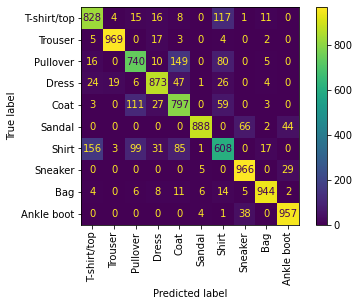

In [35]:
# Implementation of KNN with PCA: Classify test images based on PCA features using KNN

# start calculating time
start_time = time.time()

# define no. of nearest neighbours to consider
n_neighbors = 8

# Fit the classifier with training data
knnPCA = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
knnPCA.fit(trainImageRF, trainy)

# predict classes for testing data
predictedClassesPCA = knnPCA.predict(testImageRF)

# print confusion matrix to visualize misidentification
confMat=sklearn.metrics.confusion_matrix(testy, predictedClassesPCA)
labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'];
disp = sklearn.metrics.ConfusionMatrixDisplay(confMat, display_labels=labels);
cmPlot=disp.plot(xticks_rotation='vertical' ,cmap='viridis');

# calculate Classification rate
correctPCA=0
for idx,val in enumerate(predictedClassesPCA):
    if(val==testy[idx]):
        correctPCA=correctPCA+1;    
print('Classification rate ',correctPCA/100, ' %')

# calculate Misidentification rate
misIden = 100-correctPCA/100
print('Misidentification rate ',misIden, ' %')

#calculate and print elapsed time for this step
end_time = time.time()
time_elapsed = (end_time - start_time)
print('elapsed time: ',time_elapsed)


# Implementation of PCA : Dimensionality reduction for Binary Images

In [36]:
# Implementation of PCA : Dimensionality reduction using PCA

#load training and testing data
imspaceTrainX = np.load('imspaceTrainX.npy')
imspaceTestX = np.load('imspaceTestX.npy')

#initialization for scaling
scaler = StandardScaler()

# Fit scaler with training data.
scaler.fit(imspaceTrainX)

# transform and save both training and testing scaled feature array.
trainImage = scaler.transform(imspaceTrainX)
testImage = scaler.transform(imspaceTestX)

#initialize pca to select principle components with 95% variance
pca = PCA(.95)

# Fit PCA with training data.
XI=pca.fit(trainImage)

# transform and save both training and testing feature array with 95% variance
trainImage = pca.transform(trainImage)
testImage = pca.transform(testImage)

# Classify test images based on PCA based features using KNN

Classification rate  85.81  %
Misidentification rate  14.189999999999998  %
elapsed time:  31.699727296829224


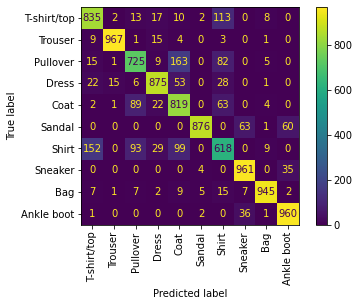

In [37]:
# Implementation of KNN with PCA: Classify test images based on PCA features using KNN

# start calculating time
start_time = time.time()

# define no. of nearest neighbours to consider
n_neighbors = 8

# Fit the classifier with training data
knnPCA = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
knnPCA.fit(trainImage, trainy)

# predict classes for testing data
predictedClassesPCA = knnPCA.predict(testImage)

# print confusion matrix to visualize misidentification
confMat=sklearn.metrics.confusion_matrix(testy, predictedClassesPCA)
labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'];
disp = sklearn.metrics.ConfusionMatrixDisplay(confMat, display_labels=labels);
cmPlot=disp.plot(xticks_rotation='vertical' ,cmap='viridis');

# calculate Classification rate
correctPCA=0
for idx,val in enumerate(predictedClassesPCA):
    if(val==testy[idx]):
        correctPCA=correctPCA+1;    
print('Classification rate ',correctPCA/100, ' %')

# calculate Misidentification rate
misIden = 100-correctPCA/100
print('Misidentification rate ',misIden, ' %')

#calculate and print elapsed time for this step
end_time = time.time()
time_elapsed = (end_time - start_time)
print('elapsed time: ',time_elapsed)


# Classify test images based on Curvature based features using KNN

Classification rate  69.88  %
Misidentification rate  30.120000000000005  %
elapsed time:  16.333794832229614


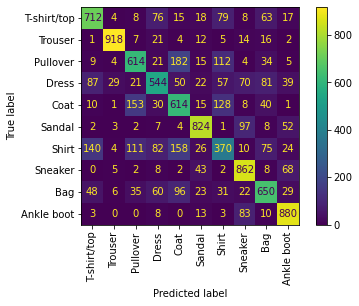

In [40]:
# Implementation of KNN : Classify test images based on curvature features using KNN

#load training and testing data
trainCurvatureArray = np.load('trainCurvature.npy')
testCurvatureArray = np.load('testCurvature.npy')

# start calculating time
start_time = time.time()

# define no. of nearest neighbours to consider
n_neighbors = 8

# Fit the classifier with training data
knnC = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
knnC.fit(trainCurvatureArray, trainy)

# predict classes for testing data
predictedClassesC = knnC.predict(testCurvatureArray)

# print confusion matrix to visualize misidentification
confMatC=sklearn.metrics.confusion_matrix(testy, predictedClassesC)
labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'];
disp = sklearn.metrics.ConfusionMatrixDisplay(confMatC, display_labels=labels);
cmPlot=disp.plot(xticks_rotation='vertical' ,cmap='viridis');

# calculate Classification rate
correctC=0
for idx,val in enumerate(predictedClassesC):
    if(val==testy[idx]):
        correctC=correctC+1;    
print('Classification rate ',correctC/100, ' %')

# calculate Misidentification rate
misIden = 100-correctC/100
print('Misidentification rate ',misIden, ' %')

#calculate and print elapsed time for this step
end_time = time.time()
time_elapsed = (end_time - start_time)
print('elapsed time: ',time_elapsed)

# Classify test images based on concatenated PCA and Curvature based features using KNN

Classification rate  85.83  %
Misidentification rate  14.170000000000002  %
elapsed time:  33.036107301712036


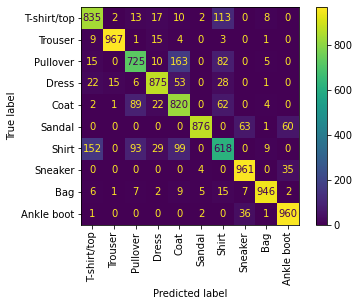

In [41]:
# Implementation of KNN with both features: Classify test images based on PCA and curvature features using KNN
 
# concatenate training and testing feature arrays
trainArray = np.concatenate((trainCurvatureArray,trainImage),axis=1);
testArray = np.concatenate((testCurvatureArray,testImage),axis=1);

# start calculating time
start_time = time.time()

# define no. of nearest neighbours to consider
n_neighbors = 8

# Fit the classifier with training data
knnCombined = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
knnCombined.fit(trainArray, trainy)

# predict classes for testing data
predictedClasses = knnCombined.predict(testArray)

# print confusion matrix to visualize misidentification
confMat=sklearn.metrics.confusion_matrix(testy, predictedClasses)
labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'];
disp = sklearn.metrics.ConfusionMatrixDisplay(confMat, display_labels=labels);
cmPlot=disp.plot(xticks_rotation='vertical' ,cmap='viridis');

# calculate Classification rate
correct=0
for idx,val in enumerate(predictedClasses):
    if(val==testy[idx]):
        correct=correct+1;    
print('Classification rate ',correct/100, ' %')

# calculate Misidentification rate
misIden = 100-correct/100
print('Misidentification rate ',misIden, ' %')


#calculate and print elapsed time for this step
end_time = time.time()
time_elapsed = (end_time - start_time)
print('elapsed time: ',time_elapsed)

# Support Vector Machine


Performance using kernel:  linear
Classification rate  85.4  %
Misidentification rate  14.599999999999994  %
elapsed time:  2429.8604412078857

Performance using kernel:  poly
Classification rate  88.63  %
Misidentification rate  11.370000000000005  %
elapsed time:  295.47394466400146

Performance using kernel:  rbf
Classification rate  88.69  %
Misidentification rate  11.310000000000002  %
elapsed time:  455.195529460907

Performance using kernel:  sigmoid
Classification rate  67.31  %
Misidentification rate  32.69  %
elapsed time:  306.58606338500977


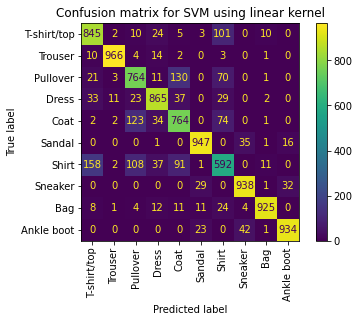

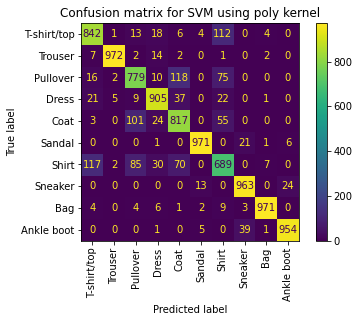

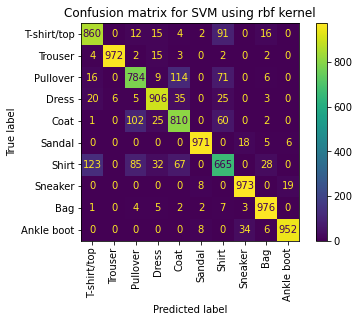

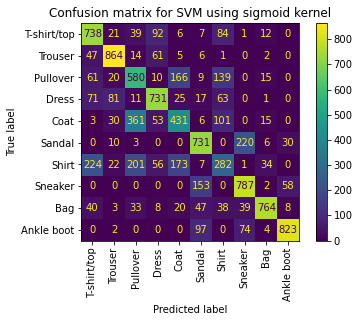

In [79]:
# Implementation of SVM with both features: Different kernels has been used to test performance

# concatenate training and testing feature arrays
trainArray = np.concatenate((trainImage,trainCurvatureArray),axis=1);
testArray = np.concatenate((testImage,testCurvatureArray),axis=1);

# define kernels
# to test for any specific kernel, delete other kernels from the following array.
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

#loop through kernels
for kernel in kernels:
    # start calculating time
    start_time = time.time()

    # Initialize a support vector classifier for multiple classes
    svmC = sklearn.svm.SVC(C=3.0, kernel=kernel, gamma='auto')

    # Fit the classifier with training data
    svmC.fit(trainArray, trainy)
    
    #Save SVM Model
    strFileName=('SVM-using-'+kernel+'.h5')
    model.save(strFileName)

    # Predict testing data using SVM
    predictedSVM = svmC.predict(testArray)
    
    #Print kernel name
    print('\nPerformance using kernel: ', kernel)
    # print confusion matrix to visualize misidentification
    confMatSVM=sklearn.metrics.confusion_matrix(testy, predictedSVM)
    labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'];
    disp = sklearn.metrics.ConfusionMatrixDisplay(confMatSVM, display_labels=labels);
    cmPlot=disp.plot(xticks_rotation='vertical' ,cmap='viridis');
    str=('Confusion matrix for SVM using '+kernel+ ' kernel')
    disp.ax_.set_title(str)

    # calculate Classification rate
    correctSVM=0
    for idx,val in enumerate(predictedSVM):
        if(val==testy[idx]):
            correctSVM=correctSVM+1;    
    print('Classification rate ',correctSVM/100, ' %')

    # calculate Misidentification rate
    misIden = 100-correctSVM/100
    print('Misidentification rate ',misIden, ' %')

    #calculate and print elapsed time for this step
    end_time = time.time()
    time_elapsed = (end_time - start_time)
    print('elapsed time: ',time_elapsed)

# Normalizing and processing training - testing data

In [59]:
#Defining input shape
img_rows, img_cols = 28, 28

# reshape train and test data for passing to CNN
trainX = trainX.reshape(trainX.shape[0], img_rows, img_cols, 1)
testX = testX.reshape(testX.shape[0], img_rows, img_cols, 1)

#normalizing and resizing
x_train = trainX[0:50000].astype('float32') / 255
x_valid = trainX[50000:60001].astype('float32') / 255
x_test = testX.astype('float32') / 255

#Printing training, validaton and testing samples count
print(x_train.shape[0], 'training samples')
print(x_valid.shape[0], 'validation samples')
print(x_test.shape[0], 'testing samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(trainy[0:50000], 10)
y_valid = np_utils.to_categorical(trainy[50000:60001], 10)
y_test = np_utils.to_categorical(testy, 10)

50000 training samples
10000 validation samples
10000 testing samples


# Designing Convolutional Neural Network Model

In [60]:
#Initialize model
model = Sequential()

#Add first set of convolutional layers
model.add(Conv2D(input_shape=(28,28,1),filters=8,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=8,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=8,kernel_size=(3,3),padding="same", activation="relu"))

#Add maxpooling layer
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#Add 2 more convolutional layers
model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))

#Add maxpooling
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#Add 2 more convolutional layers
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))

#Add maxpooling
model.add(MaxPooling2D(pool_size=(2,2),padding="same", strides=(2,2)))

#reducing the network size to avoid overfitting
model.add(Dropout(0.50))

#flattening the data in one column
model.add(Flatten())

#Add fully connected dense layers
model.add(Dense(units=256,activation="relu"))
model.add(Dense(units=64,activation="relu"))

#reducing the network size to avoid overfitting
model.add(Dropout(0.5))

#Final output layer of 10 classes
model.add(Dense(10, activation='softmax'))

# Compiling the CNN with adam optimizer
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#printing the model summary
model.summary();

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)         

# Train and save the CNN network

In [61]:
# initialize Checkpoint and EarlyStopping parameters
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

#Training the model
hist = model.fit(x_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint,early])

# Save the model
model.save('Fashion-MNIST-CNN.h5')
print("Saved model to disk")


Epoch 1/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.7449 - accuracy: 0.7273 ETA
Epoch 00001: val_accuracy improved from -inf to 0.84970, saving model to vgg16_1.h5
1563/1563 [==============================] - 86s 55ms/step - loss: 0.7448 - accuracy: 0.7273 - val_loss: 0.4117 - val_accuracy: 0.8497
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.4670 - accuracy: 0.8354 ETA: 0s - loss: 0.4675 - 
Epoch 00002: val_accuracy improved from 0.84970 to 0.87300, saving model to vgg16_1.h5
1563/1563 [==============================] - 89s 57ms/step - loss: 0.4670 - accuracy: 0.8354 - val_loss: 0.3555 - val_accuracy: 0.8730
Epoch 3/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.4028 - accuracy: 0.8588 ETA: 0s - loss:
Epoch 00003: val_accuracy improved from 0.87300 to 0.88370, saving model to vgg16_1.h5
1563/1563 [==============================] - 88s 56ms/step - loss: 0.4028 - accuracy: 0.8588 - val_loss: 0.3219 - val_accuracy: 0.88

Epoch 28/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9244
Epoch 00028: val_accuracy did not improve from 0.92220
1563/1563 [==============================] - 89s 57ms/step - loss: 0.2107 - accuracy: 0.9244 - val_loss: 0.2396 - val_accuracy: 0.9148
Epoch 29/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.2154 - accuracy: 0.9221
Epoch 00029: val_accuracy did not improve from 0.92220
1563/1563 [==============================] - 89s 57ms/step - loss: 0.2153 - accuracy: 0.9221 - val_loss: 0.2357 - val_accuracy: 0.9171
Epoch 30/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9254 ETA: 1s -
Epoch 00030: val_accuracy did not improve from 0.92220
1563/1563 [==============================] - 89s 57ms/step - loss: 0.2087 - accuracy: 0.9254 - val_loss: 0.2366 - val_accuracy: 0.9206
Epoch 31/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.2117 - accuracy: 0.9234 ETA: 1s - los
Epoch 0003

# Predict testing data using the Trained Model

Classification rate  92.26  %
Misidentification rate  7.739999999999995  %
elapsed time:  4.128775358200073


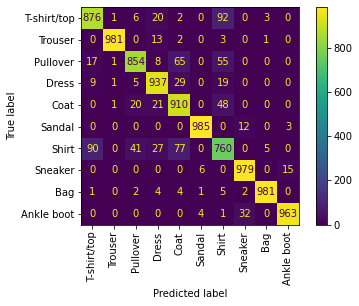

In [69]:
# load model
model = load_model('Fashion-MNIST-CNN.h5')

# start calculating time
start_time = time.time()

#Calculating the score of the model
score = model.predict(x_test, verbose=0)

# Prepare data for calculating accuracy
testy= np.argmax(y_test, axis=1, out=None)
predCNN = np.argmax(score, axis=1, out=None)

# print confusion matrix to visualize misidentification
confMatCNN=sklearn.metrics.confusion_matrix(testy, predCNN)
labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'];
disp = sklearn.metrics.ConfusionMatrixDisplay(confMatCNN, display_labels=labels);
cmPlot=disp.plot(xticks_rotation='vertical' ,cmap='viridis');

# calculate Classification rate
correctCNN=0
for idx,val in enumerate(predCNN):
    if(val==testy[idx]):
        correctCNN=correctCNN+1;    
print('Classification rate ',correctCNN/100, ' %')

# calculate Misidentification rate
misIden = 100-correctCNN/100
print('Misidentification rate ',misIden, ' %')

#calculate and print elapsed time for this step
end_time = time.time()
time_elapsed = (end_time - start_time)
print('elapsed time: ',time_elapsed)